In [1]:
from mitools import reg
import numpy as np
import pandas as pd

from linearmodels.datasets import munnell, fringe, french
from collections import OrderedDict
import matplotlib.pyplot as plt
import statsmodels.api as sm
import seaborn as sns

# SUR Model from Linearmodels

https://bashtage.github.io/linearmodels/system/examples/examples.html

## Examples

System regression simultaneously estimates multiple models. This has three distinct advantages:

Joint inference across models

Linear restrictions can be imposed on the parameters across different models

Improved precision of parameter estimates (depending on the model specification and data)

There are $K$ models and each model can be expressed in vector notation as $$Y_{i} = X_{i}\beta_{i} + \epsilon_{i}$$ so that the set of models can be expressed as $$Y = X\beta + \epsilon$$ where $Y$ is a column vector that stacks the vectors $Y_{i}$ for $i = 1,2,...,K$, $X$ is a block-diagonal matrix where diagonal block $i$ is $X_{i}$, $\beta$ is a stacked vector of the $K$ $\beta_{i}$s and $\epsilon$ is similarly comprised of the stacked columns of $\epsilon_{i}$.

The model can be estimated using OLS with the usual estimator $$\hat{\beta}_{OLS} = (X'X)^{-1}X'Y.$$

Since there are multiple series, a GLS estimator that accounts for the cross-sectional heteroskedasticity as well as the correlation of residuals can be estimated $$\hat{\beta}_{GLS} = (X'\Omega^{-1} X)^{-1}X'\Omega^{-1}Y.$$ where $\Omega^{-1} = \sum^{-1}\bigotimes I_{T},\sum_{ij}$ is the covariance between $\epsilon_{i}$ and $\epsilon_{j}$ and $T$ is the number of observations. The GLS estimator is only beneficial when the regressors in different models differ and when residuals are correlated. There GLS estimates are identical to the multicariate OLS estimates when all regressors are common.

## Data

Two data sets will be used. The first is from Munnell which looks at the effect of capital on state GDP. This example follows the example in Chapter 10 in recent editions of Greene”s Econometric Analysis.

The data is state-level but the model is estimated in region. The first step is to aggregate the data by region. All capital measures are summed and the unemployment rate is averaged using weights proportional to the total employment in each state.



In [2]:
data = munnell.load()
regions = {
    "GF": ["AL", "FL", "LA", "MS"],
    "MW": ["IL", "IN", "KY", "MI", "MN", "OH", "WI"],
    "MA": ["DE", "MD", "NJ", "NY", "PA", "VA"],
    "MT": ["CO", "ID", "MT", "ND", "SD", "WY"],
    "NE": ["CT", "ME", "MA", "NH", "RI", "VT"],
    "SO": ["GA", "NC", "SC", "TN", "WV", "AR"],
    "SW": ["AZ", "NV", "NM", "TX", "UT"],
    "CN": ["AK", "IA", "KS", "MO", "NE", "OK"],
    "WC": ["CA", "OR", "WA"],
}
def map_region(state):
    for key in regions:
        if state in regions[key]:
            return key
data["REGION"] = data.ST_ABB.map(map_region)
data["TOTAL_EMP"] = data.groupby(["REGION", "YR"])["EMP"].transform("sum")
data["EMP_SHARE"] = data.EMP / data.TOTAL_EMP
data["WEIGHED_UNEMP"] = data.EMP_SHARE * data.UNEMP

A  `groupby` transformation is used to aggregate the data, and finally all values except the unemployment rate are logged.

In [3]:
grouped = data.groupby(["REGION", "YR"])
agg_data = grouped[["GSP", "PC", "HWY", "WATER", "UTIL", "EMP", "WEIGHED_UNEMP"]].sum()
for col in ["GSP", "PC", "HWY", "WATER", "UTIL", "EMP"]:
    agg_data["ln" + col] = np.log(agg_data[col])
agg_data["UNEMP"] = agg_data.WEIGHED_UNEMP
agg_data["Intercept"] = 1.0

## Basic Usage

Seemingly Unrelated Models are fairly complex and each equation could have a different number of regressors. As a result, it is not possibly to use standard `pandas` or `numpy` data structures, and so dictionaries (or technically dictionary-like objects) are used. In practice, it is strongly recommended to use a `OrderedDictionary` from the `collections` module. This ensures that equation order will be preserved. In addition, the dictionary must have the following structure:

* `keys` **must be strings** and will be used as equation labels

* The value associated with each key must be either a dictionary or a tuple.

    * When a dictionary is used, it must have two keys, `dependent` and `exog`. It can optionally have a third key `weights` which provides weights to use in the regression.

    * When a tuple is used, it must have two elements and takes the form (dependent, exog). It can optionally contains weights in which case it takes the form (`dependent`, `exog`, `weights`).

This example uses the dictionary syntax to contain the data for each region and uses the region identified as the equation label.

In [4]:
mod_data = OrderedDict()
for region in ["GF", "SW", "WC", "MT", "NE", "MA", "SO", "MW", "CN"]:
    region_data = agg_data.loc[region]
    dependent = region_data.lnGSP
    exog = region_data[
        ["Intercept", "lnPC", "lnHWY", "lnWATER", "lnUTIL", "lnEMP", "UNEMP"]
    ]
    mod_data[region] = {"dependent": dependent, "exog": exog}

Fitting the model is virtually identical to fitting any other model with the exception of the special data structure required.

The fitting options here ensure that the homoskedastic covariance estimator are used (`cov_type="unadjusted"`) and that a small sample adjustment is applied. By default, GLS is used (this can be overridden using `method="ols"`.

In [5]:
model = reg.SURModel(equations_data=mod_data)
res = model.fit(cov_type="unadjusted")

One of the requirements for there to be an efficiency gain in a SUR is that the residuals are correlated. A heatmap is used to inspect this correlation, which is substantial and varies by region.

In [ ]:
cov = res.sigma
std = np.sqrt(np.diag(res.sigma)[:, None])
regions = [k for k in mod_data.keys()]
corr = pd.DataFrame(cov / (std @ std.T), columns=regions, index=regions)

sns.heatmap(corr, vmax=0.8, square=True)
plt.show()

corr.style.format("{:0.3f}")

These values can be seen to be identical to the reported results in the existing example from Greene.

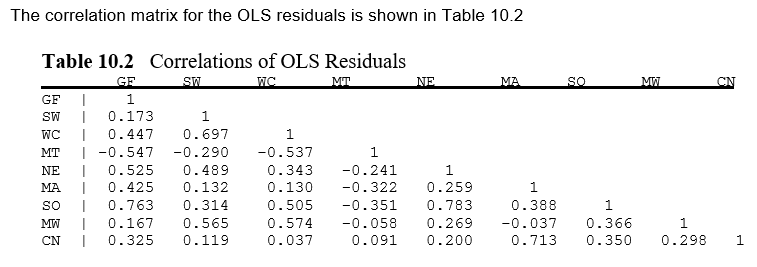

The full result is fairly long and so here I only print the first 33 lines which show results for two regions. By default it reports all estimates along with the usual measures of precision.

In [ ]:
print("\n".join(res.summary.as_text().split("\n")[:33]))

Individual results are contained in a dictionary located at the attribute `equations` and can be accessed using equation labels (available using the attribute `equation_labels`). Additional information about the model is presented in this view. The West Coast results are show.

In [ ]:
print(res.equations["WC"])

The current version of the model does not facilitate cross equation comparisons and so this is manually implemented here.

In [ ]:
# TODO: Implement method to compare across equations
params = []
for label in res.equation_labels:
    params.append(res.equations[label].params)
params = pd.concat(params, axis=1)
params.columns = res.equation_labels
params.T.style.format("{:0.3f}")

These results can be compared to the results in Greene – they are unsurprisingly identical.

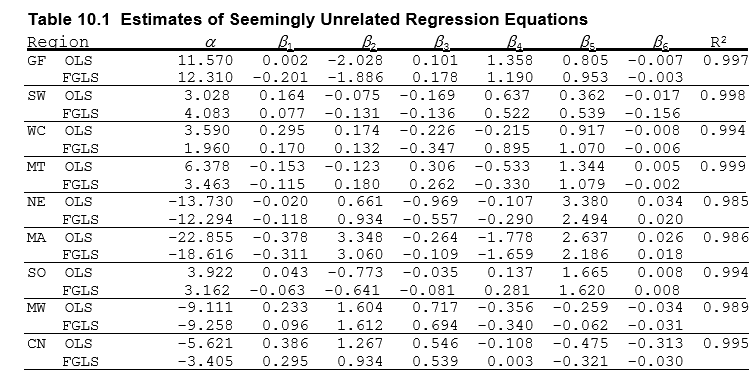

The GLS estimation method requires stronger assumptions for parameter estimates to be consistent. If these are violated then it might be the case that OLS is still consistent (in some sense) and so OLS can be used by passing `method="ols"` when calling `fit`.

These results can be compared to Greene”s table – they are identical except the final value which seems to have a small typo.

In [ ]:
res_ols = model.fit(method="ols", debiased=True, cov_type="unadjusted")
params = []
r2 = []
for label in res.equation_labels:
    params.append(res_ols.equations[label].params)
    r2.append(res_ols.equations[label].rsquared)
params = pd.concat(params, axis=1)
params.columns = res.equation_labels
params = params.T
params["R2"] = r2
params.style.format("{:0.3f}")

The parameter estimates for one coefficient – unemployment – can be compared across the two estimation methods.

In [ ]:
params = pd.concat(
    [
        res_ols.params.iloc[1::7],
        res_ols.std_errors.iloc[1::7],
        res.params.iloc[1::7],
        res.std_errors.iloc[1::7],
    ],
    axis=1,
)
params.columns = ["OLS", "OLS se", "GLS", "GLS se"]
params.index = regions
params

The parameters and their standard errors match those reported in Greene.

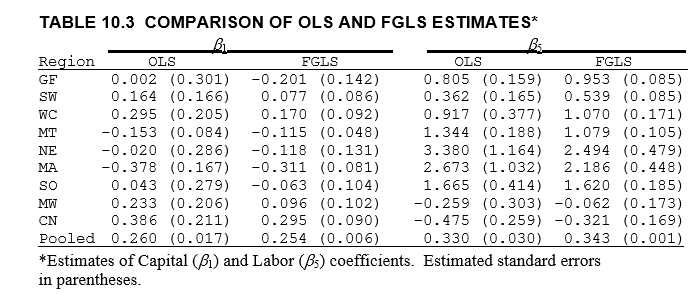

## Estimation Options

### Iterative GLS

These next examples use data on fringe benefits from F. Vella (1993), “A Simple Estimator for Simultaneous Models with Censored Endogenous Regressors” which appears in Wooldridge (2002). The model consists of two equations, one for hourly wage and the other for hourly benefits. The initial model uses the same regressors in both equations.

In [ ]:
print(fringe.DESCR)
fdata = fringe.load()

The estimated model is reported as “System OLS Estimation” since when all regressors are identical, OLS is used since GLS brings no efficiency gains. OLS will be used when the data structure containing the exogenous regressors in each equations is the same (i.e., `id(exog)` is the same for all equations).

In [ ]:
exog = sm.add_constant(
    fdata[
        [
            "educ",
            "exper",
            "expersq",
            "tenure",
            "tenuresq",
            "union",
            "south",
            "nrtheast",
            "nrthcen",
            "married",
            "white",
            "male",
        ]
    ]
)
fmod_data = OrderedDict()
fmod_data["hrearn"] = {"dependent": fdata.hrearn, "exog": exog}
fmod_data["hrbens"] = {"dependent": fdata.hrbens, "exog": exog}
fmod = reg.SUR(fmod_data)
print(fmod.fit(cov_type="unadjusted"))

The estimator can be forced to use GLS by setting `method="gls"`. As can be seen below, the parameter estimates and standard errors do not change even though two-stage GLS is used. The **$R^{2}$ does change** since the left-hand side variable is transformed by the GLS weighting before estimation.

In [ ]:
print(fmod.fit(method="gls", cov_type="unadjusted"))

The regressors must differ in order to see gains to GLS. Here insignificant variables are dropped from each equation so that the regressors will no longer be identical. The typical standard error is marginally smaller, although this might be due to dropping regressors.

In [ ]:
exog_earn = sm.add_constant(
    fdata[["educ", "exper", "expersq", "union", "nrtheast", "white"]]
)
exog_bens = sm.add_constant(
    fdata[["educ", "exper", "expersq", "tenure", "tenuresq", "union", "male"]]
)
fmod_data["hrearn"] = {"dependent": fdata.hrearn, "exog": exog_earn}
fmod_data["hrbens"] = {"dependent": fdata.hrbens, "exog": exog_bens}
fmod = reg.SUR(fmod_data)
print(fmod.fit(cov_type="unadjusted"))

The standard method to estimate models uses two steps. The first uses OLS to estimate the parameters so that the residual covariance can be estimated. The second stage uses the estimated covariance to estimate the model via GLS. Iterative GLS can be used to continue these iterations using the most recent step to estimate the residual covariance and then re-estimating the parameters using GLS. This option can be used by setting `iterate=True`.

In [ ]:
fmod_res = fmod.fit(cov_type="unadjusted", iterate=True)
print(fmod_res)

The number of GLS iterations can be verified using the `iterations` attribute of the results.

In [ ]:
fmod_res.iterations

### Alternative Covariance Estimators

The estimator supports heteroskedasticity robust covariance estimation b setting `cov_type="robust"`. The estimator allows for arbitrary correlation across series with the same time index but not correlation across time periods, which is the same assumption as in the unadjusted estimator. The main difference is that this estimator will correct standard errors for dependence between regressors (or squared regressors) and squared residuals.

#### Heteroskedasticity Robust Covariance Estimation

In the fringe benefit model there are some large differences between standard errors computed using the the homoskedastic covariance estimator and the heteroskedasticity robust covariance estimator (e.g., `exper`).

In [ ]:
fres_het = fmod.fit(cov_type="robust")
print(fres_het.summary)

Other supported covariance estimators include `"kernel”` which implements a HAC and `"clustered"` which supports 1 and 2-way clustering.

#### Kernel (HAC)

The supported kernels are `"bartlett"` (Newey-West), `"parzen"` (Gallant), and `qs` (Quadratic Spectral, Andrews). This example uses the Parzen kernel. The kernel’s bandwidth is computed automatically if the parameter `bandwidth` is not provided.

In [ ]:
hac_res = fmod.fit(cov_type="kernel", kernel="parzen")
print(hac_res.summary)

#### Clustered (Rogers)

The clustered covariance estimator requires the clusters to be entered as a NumPy array with shape `(nobs, 1)` or `(nobs, 2)`. This example uses random clusters to illustrate the structure of the group id variable.

In [ ]:
rs = np.random.RandomState([983476381, 28390328, 23829810])
random_clusters = rs.randint(0, 51, size=(616, 1))
clustered_res = fmod.fit(cov_type="clustered", clusters=random_clusters)
print(clustered_res.summary)

## Prespecified Residual Covariance Estimators

The GLS estimator can be used with a user specified covariance. This example uses a covariance where all correlations are identical (equicorrelation) in the state GDP model. The estimator must be used when constructing the model through the `sigma` keyword argument.

In [ ]:
avg_corr = (corr - np.eye(9)).mean().mean() * (81 / 72)
rho = np.ones((9, 9)) * avg_corr + (1 - avg_corr) * np.eye(9)
sigma_pre = rho * (std @ std.T)

mod_pre_sigma = reg.SUR(mod_data, sigma=sigma_pre)
res_pre = mod_pre_sigma.fit(cov_type="unadjusted", debiased=True)
print(res_pre.equations["GF"])


### Diagonal Residual Covariance

The default assumption is that there can be arbitrary correlation between series. The model can be estimated assuming no correlation but different variance by setting the keyword argument `full_cov=False` in the `fit` method. This is only useful when there are cross-equation parameter restrictions.

## Cross-Equation Restrictions

One of the more useful features of using a SUR to estimate a system is the ability to impose constraints on parameters across equations. Here only linear constraints of the form $$r\beta = q$$

are supported. Linear constraints are entered by passing a `DataFrame` with the shape number of constraints by number of parameters. The number and name of parameters can be seen by inspecting the `param_names` attribute of a model. Below are the parameter names from the state GDP model which consist of the equation label, an underscore, and the variable name. This ensures uniqueness.

In [ ]:
model.model.param_names[:14]

The example of a parameter constraint will enforce a common value of the coefficient of unemployment in all equations. This restriction takes the form $$\beta_{unemp,i} - \beta_{unemp,j} = 0$$ where in all examples i is the first series and j is one of the 8 others. In total there are 8 restrictions.

The construction of the restriction array and the non-zero columns are shown below.

In [ ]:
r = pd.DataFrame(
    columns=model.model.param_names,
    index=["rest{0}".format(i) for i in range(8)],
    dtype=np.float64,
)
r.loc[:, :] = 0.0
r.iloc[:, 6] = -1.0
r.iloc[:, 13::7] = np.eye(8)
print(r.iloc[:, 6::7])

The constraint can be added to an existing model using the `add_constraint` method. This method requires one input, `r` and optionally `q`. if `q` is not provided, it is set to 0.

Here the constraint is added, the model is estimated, and the parameters for unemployment are displayed. They all have the same value.

In [ ]:
constrained_res = model.fit(constraints=r)
constrained_res.params[6::7]

### Pooling using constraints

More complicated constraints can be used to produce interesting models. Using the same idea as the previous set of constraints, a pooled SUR (excluding the constant) is constructed by restricting all coefficients to have the same value. Here the form of the restriction is $$\beta_{var,0} - \beta_{var,j} = 0$$ so that the restriction is identical to the previous, only applied to all variables excluding the constant.

Here the estimated from the first two equations are shown. All coefficients except the intercept are identical across equations.

Note: When linear constraints are imposed, the parameter covariance matrix will be singular. Caution is needed to ensure test statistics are meaningful.

In [ ]:
r2 = np.zeros((8 * 6, r.shape[1]))
loc = 0
for i in range(6):
    for j in range(8):
        r2[loc, i + 1] = -1.0
        r2[loc, 7 * (j + 1) + i + 1] = 1.0
        loc += 1
r2 = pd.DataFrame(r2, columns=model.model.param_names)
pooled_res = model.fit(constraints=r2)
print("\n".join(pooled_res.summary.as_text().split("\n")[:33]))

## Multivariate OLS

One final feature worth demonstrating is a simple interface for specifying multivariate OLS models. These models have the same regressors and so it is possible to specify them with two arrays. The first is a $T$ by $K$ array of dependent variables where each column contains a dependent variable. The second contains the common exogenous regressors.

This example shows how a CAPM can be estimated as a MV OLS.

In [ ]:
data = french.load()
factors = sm.add_constant(data[["MktRF"]])
mv_ols = reg.SUR.multivariate_ls(
    data[["S1V1", "S1V3", "S1V5", "S5V1", "S5V3", "S5V5"]], factors
)
mv_ols_res = mv_ols.fit(cov_type="unadjusted")
print(mv_ols_res)

### Using GLS with common regressors

As noted previously, forcing GLS has no effect (except on changing the $R^{2}$). This can be seen below.

In [ ]:
print(mv_ols.fit(cov_type="unadjusted", method="gls"))

***